In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import os


gridFile="/Users/james/Documents/Github/esm_lab/gridTools/nep7_grid/ocean_hgrid.nc"
#gridFile = "/Users/james/Downloads/gridFile.nc"
topoFile="/Users/james/Downloads/gebco_2020_netcdf/GEBCO_2020.nc"
gridGeoLoc = "corner"
topoVarName = 'elevation'
periodic=True
method='conservative'
gridLatName = None
gridLonName = None
topoLatName = None
topoLonName = None
topoDimX = None
topoDimY = None
coarsenInt = 8
grid = xr.open_dataset(gridFile)


In [2]:
gridGeoLoc = 'corner'
if gridGeoLoc == "center":
    if 'nx' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nx"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nx"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nx"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nx"})
        else:
            print ('Error: plase define gridDimX')
    if 'ny' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "ny"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "ny"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "ny"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "ny"})
        else:
            print ('Error: plase define gridDimY')
    
    if 'lat_centers' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_centers'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_centers'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_centers'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_centers'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_centers' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_centers'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_centers'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_centers'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_centers'})
        else:
            print('Error: Please define gridLonName')
    
    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_centers = grid['lon_centers'].values
    lat_centers = grid['lat_centers'].values
    
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lon_corners.shape[0] + 1, lon_corners.shape[1] + 1))
    filler_array[0:lon_corners.shape[0], 0:lon_corners.shape[1]] = lon_corners[:,:]
    extCol = np.append(np.diff(lon_corners[:,-1]), np.diff(lon_corners[:,-1])[-1])  + lon_corners[:,-1]
    extRow = np.append(np.diff(lon_corners[-1,:], axis=0), np.diff(lon_corners[-1,:], axis=0)[-1])  + lon_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lon_corners[-1,:])[-1]*2  + lon_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    # plt.pcolormesh(filler_array)
    grid['lon_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )
    
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lat_corners.shape[0] + 1, lat_corners.shape[1] + 1))
    filler_array[0:lat_corners.shape[0], 0:lat_corners.shape[1]] = lat_corners[:,:]
    extCol = np.append(np.diff(lat_corners[:,-1]), np.diff(lat_corners[:,-1])[-1])  + lat_corners[:,-1]
    extRow = np.append(np.diff(lat_corners[-1,:], axis=0), np.diff(lat_corners[-1,:], axis=0)[-1])  + lat_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lat_corners[-1,:])[-1]*2  + lat_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    #plt.pcolormesh(filler_array)
    # add formal lat corner to grid object
    grid['lat_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
if gridGeoLoc == "corner":
    # organize dimensions to nx ny nxp nyp
    if 'nxp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nxp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nxp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nxp"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nxp"})
        else:
            print ('Error: plase define gridDimX')
    if 'nyp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "nyp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "nyp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "nyp"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "nyp"})
        else:
            print ('Error: plase define gridDimY')
            
    if 'lat_corners' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_corners'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_corners'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_corners'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_corners'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_corners' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_corners'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_corners'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_corners'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_corners'})
        else:
            print('Error: Please define gridLonName')

    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_corners = grid['lon_corners'].values
    lat_corners = grid['lat_corners'].values
    
    # To use conservative regidding, we need the cells centers. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_centers = 0.25 * (
        lon_corners[:-1, :-1]
        + lon_corners[1:, :-1]
        + lon_corners[:-1, 1:]
        + lon_corners[1:, 1:]
    )
    
    lat_centers = 0.25 * (
        lat_corners[:-1, :-1]
        + lat_corners[1:, :-1]
        + lat_corners[:-1, 1:]
        + lat_corners[1:, 1:]
    )
    
    grid['lat_centers'] = xr.DataArray(data=lat_centers, dims=("ny", "nx"))
    grid['lon_centers'] = xr.DataArray(data=lon_centers, dims=("ny", "nx"))
    

    
# note here that we will automatically declare that the bath/topo grid is defined by the centers
# TOPOGRAPHY XARRAY OBJECT ORGANIZATION
# TOPOGRAPHY XARRAY OBJECT ORGANIZATION
topo = xr.open_dataset(topoFile)

if 'nx' not in topo.dims:
    if topoDimX != None:
        topo = topo.rename_dims({topoDimX : "nx"})
    elif 'lon' in topo.dims:
        topo = topo.rename_dims({"lon" : "nx"})
    elif 'longitude' in topo.dims:
        topo = topo.rename_dims({"longitude" : "nx"})
    elif 'x' in topo.dims:
        topo = topo.rename_dims({"x" : "nx"})
    else:
        print ('Error: plase define topoDimX')
if 'ny' not in topo.dims:
    if topoDimY != None:
        topo = topo.rename_dims({topoDimY : "ny"})
    elif 'lat' in topo.dims:
        topo = topo.rename_dims({"lat" : "ny"})
    elif 'latitude' in topo.dims:
        topo = topo.rename_dims({"latitude" : "ny"})
    elif 'y' in topo.dims:
        topo = topo.rename_dims({"y" : "ny"})
    else:
        print ('Error: plase define topoDimY')
        
# coarsen topo file down based on coarsenInt
topo = topo.coarsen(nx=coarsenInt,ny=coarsenInt, boundary='pad').median()

if 'lat_centers' not in topo.variables:
    if topoLatName != None:
        topo = topo.rename({topoLatName: 'lat_centers'})
    elif 'y' in topo.variables:
        topo = topo.rename({'y': 'lat_centers'})
    elif 'lat' in topo.variables:
        topo = topo.rename({'lat': 'lat_centers'})
    elif 'latitude' in topo.variables:
        topo = topo.rename({'latitude': 'lat_centers'})
    else:
        print('Error: please define gridlatname')
if 'lon_centers' not in topo.variables:
    if topoLonName != None:
        topo = topo.rename({topoLonName : 'lon_centers'})
    elif 'x' in topo.variables:
        topo = topo.rename({'x': 'lon_centers'})
    elif 'lon' in topo.variables:
        topo = topo.rename({'lon': 'lon_centers'})
    elif 'longitude' in grid.variables:
        topo = topo.rename({'longitude': 'lon_centers'})
    else:
        print('Error: Please define gridLonName')


# grab index location of grid extents
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# if longitudes are 0 to 360, convert to -180 to 180
if "lon_centers" in topo.coords:
    topo = topo.assign_coords(lon_centers=(np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, 
                                                    topo['lon_centers'].values)))
    topo = topo.swap_dims({'lon_centers' : 'nx'})
if "lon_centers" in topo.data_vars:
    topo['lon_centers'].values =  np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, topo['lon_centers'].values)


latMinInd = find_nearest(array = topo.lat_centers.values, value = np.min(grid.lat_centers.values))
latMaxInd = find_nearest(array = topo.lat_centers.values, value = np.max(grid.lat_centers.values))
lonMinInd = find_nearest(array = topo.lon_centers.values, value = np.min(grid.lon_centers.values))
lonMaxInd = find_nearest(array = topo.lon_centers.values, value = np.max(grid.lon_centers.values))

if lonMinInd > lonMaxInd:
    temp = lonMinInd
    lonMinInd = lonMaxInd
    lonMaxInd = temp

# slice the large topography file down to the extents of the grid file + 1 on either side because we will slice down 2 points 
# after the corner points are calculated
topo = topo.isel(nx=slice(lonMinInd - 1, lonMaxInd + 1), ny=slice(latMinInd - 1, latMaxInd + 1))

lon_centers = topo['lon_centers'].values
lat_centers = topo['lat_centers'].values

lon_corners = 0.25 * (
    lon_centers[:-1]
    + lon_centers[1:]
    + lon_centers[:-1]
    + lon_centers[1:]
)

lat_corners = 0.25 * (
    lat_centers[:-1]
    + lat_centers[1:]
    + lat_centers[:-1]
    + lat_centers[1:]
)

# trim down the centers so they are 1 less than the corner points we just calculated
topo = topo.isel(nx=slice(1,-1), ny=slice(1,-1))

# extract the topo values and add them back later with proper dimensions
elev = topo[topoVarName].values

# add nxp and nyp dimensions for the lat/lon corners to latch onto
topo = topo.expand_dims({'nyp':(len(topo.ny) + 1)})
topo = topo.expand_dims({'nxp':(len(topo.nx) + 1)})

# add the lat/lon corners as data variables
topo['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
topo['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))

# drop elevation and bring it back, this time constraining the dimensions to lat/lon centers
topo = topo.drop_vars(topoVarName)
topo[topoVarName] = (('ny', 'nx'), elev)

# make lat/lons 2 dimensions just like the grids wewe are matching to
lon2d, lat2d = np.meshgrid(topo.lon_centers.values, topo.lat_centers.values)
lon2d_b, lat2d_b = np.meshgrid(topo.lon_corners.values, topo.lat_corners.values)

# assign 2d coordinates as lat/lon 
topo = topo.assign_coords({"lon" : (("ny", "nx"), lon2d)})
topo = topo.assign_coords({"lat" : (("ny", "nx"), lat2d)})
topo = topo.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
topo = topo.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})

# rename for xesmf
grid["lon"] = grid["lon_centers"]
grid["lat"] = grid["lat_centers"]
grid["lon_b"] = grid["lon_corners"]
grid["lat_b"] = grid["lat_corners"]

        
# convert topography variable to a depth variable
ds = topo[topoVarName]
# create ocean fraction array where ocean cells are 1 and land cells are 0
lm_ds = topo[topoVarName].where(topo[topoVarName] < 0)
lm_ds = lm_ds.fillna(0)
lm_ds = lm_ds.where(lm_ds > -0.000001)
lm_ds = lm_ds.fillna(1)
lm_ds.name = 'mask'
lm_ds.attrs['units'] = 'ocean fraction at T-cell centers'

# add landmask to the topography dataset - this is only for numpyRegridder
topo['landmask'] = (('ny', 'nx'), lm_ds)

In [19]:
np.max(grid.lon_centers.values)

179.9537

In [20]:
backup = topo

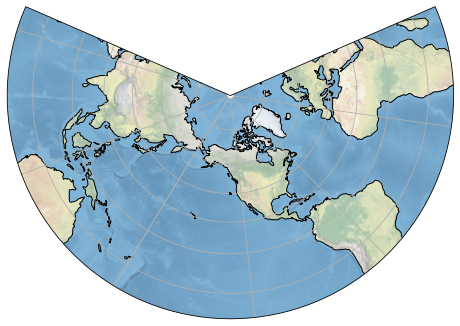

In [284]:
# plot grid

import cartopy.crs as crs
import numpy as np
import matplotlib.pyplot as plt
#standard_parallels = (lat_1, lat_2)
lon0=230
lat0=40
standard_parallels=(25, 55)

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=crs.LambertConformal(central_longitude=lon0, central_latitude=lat0))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
(nj,ni) = grid.lat.shape 
for i in range(0,ni,2):
    ax.plot(grid.lon[:,i], grid.lat[:,i], 'k', transform=crs.LambertConformal(central_longitude=230, central_latitude=40, standard_parallels=standard_parallels))
for j in range(0,nj,2):
    ax.plot(grid.lon[j,:], grid.lat[j,:], 'k', transform=crs.LambertConformal(central_longitude=230, central_latitude=40, standard_parallels=standard_parallels))
                

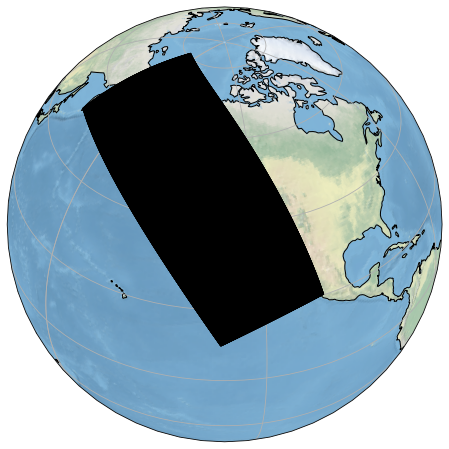

In [285]:

import cartopy.crs as crs
import numpy as np
import matplotlib.pyplot as plt
lon0=230
lat0=40
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
nj = grid.dims['nyp']
ni = grid.dims['nxp']

transform=crs.Geodetic()
iColor='k'
iLinewidth=2
jColor='k'
jLinewidth=2

for i in range(0,ni+1,2):
    if i <= ni-1:
            ax.plot(grid['lon_corners'][:,i], grid['lat_corners'][:,i], iColor, linewidth=iLinewidth, transform=transform)
for j in range(0,nj+1,2):
    if j <= nj-1:
            ax.plot(grid['lon_corners'][j,:], grid['lat_corners'][j,:], jColor, linewidth=jLinewidth, transform=transform)

In [74]:
len(range(0,ni+1,2))

21

In [6]:
def numpyRegridder(gridXr, topoXr, topoVarName='elevation',numMethod='median', superGrid=True):
    """
    Regrid topography file to the grid of a given grid file using numpy. Available for 'median' and 'mean' methods. For each grid cell of the grid file, the corners of the cell are used as a bounding box for the higher resolution topography file. Once the cell has been geopositioned on the topography file, the 'median' or 'mean' is calculated and the value is subsequently placed in the grid file grid cell. It is also assumed that the topography values are defined at the cell centers. We recommend using GEBCO2020 topography dataset for the topography file. It can be found here: https://www.gebco.net/data_and_products/gridded_bathymetry_data/

    gridXr: grid xarray object with appropriate organization (lat/lon centers/corners defined with nx/ny nxp/nyp dimensions - this happens automatically within regridTopo())
    topoXr: topography xarray object (lat/lon centers/corners defined with nx/ny nxp/nyp dimensions - this happens automatically within regridTopo())
    numMethod: Numpy method for calculation - 'median', 'mean' are currently supported operations.
    superGrid: When true, this assumes the gridFile is a supergrid and the resulting topography is coarsened to a regular grid.
    """
    njp = gridXr.dims['nyp']
    nip = gridXr.dims['nxp']

    if superGrid==True:
        superInt=2
    else:
        superInt=1
    topo_out = xr.Dataset({
        topoVarName: xr.DataArray(
                    data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                    dims   = ['ny', 'nx'],
                    attrs  = {
                        'units'     : 'm'
                        }
                    ),
        'landmask': xr.DataArray(
                    data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                    dims   = ['ny', 'nx'],
                    attrs  = {
                        'units'     : 'ocean fraction at T Cell Centers'
                        }
                    ),
        'lon_corners': xr.DataArray( 
                data   = gridXr['lon_corners'].values[::superInt,::superInt],   # enter data here
                dims   = ['nyp', 'nxp'],
                attrs  = {
                    'units'     : 'degrees'
                    }
                ),
        'lat_corners': xr.DataArray(
                data   = gridXr['lat_corners'].values[::superInt,::superInt],   # enter data here
                dims   = ['nyp', 'nxp'],
                attrs  = {
                    'units'     : 'degrees'
                    }
                ),
        'lon_centers': xr.DataArray( 
                data   = gridXr['lon_centers'].values[::superInt,::superInt],   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'degrees'
                    }
                ),
        'lat_centers': xr.DataArray(
                data   = gridXr['lat_centers'].values[::superInt,::superInt],   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'degrees'
                    }
                )},
            #attrs = {'projection': gridXr.attrs['projection']}
        )

    for i in range(0,nip-1,superInt):
        for j in range(0,njp-1,superInt):
            latMinInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j,i])
            latMaxInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j+1,i+1])
            lonMinInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j,i])
            lonMaxInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j+1,i+1])

            # clause in case we are dealing with datasets stored backwards - this matters because of the slice order xarray requires
            if lonMinInd > lonMaxInd:
                tem_ind = lonMinInd
                lonMinInd = lonMaxInd
                lonMaxInd = tem_ind

            # select bounding box for the topography dataset based on indices of the gridXr file corners - perform desired computation (median, mean, min, max) on matrix 
            if numMethod=='median':
                tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

                # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
                if np.isnan(tem_topo) == True: 
                    lonMinInd = lonMaxInd
                    lonMaxInd = lonMaxInd + lonDiffInd
                    latMinInd = latMaxInd
                    latMaxInd = latMaxInd + latDiffInd
                    tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                    tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            if numMethod=='mean':
                tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

                # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
                if np.isnan(tem_topo) == True: 
                    lonMinInd = lonMaxInd
                    lonMaxInd = lonMaxInd + lonDiffInd
                    latMinInd = latMaxInd
                    latMaxInd = latMaxInd + latDiffInd
                    tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                    tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            oj = int(j/superInt)
            oi = int(i/superInt)
            topo_out[topoVarName][oj,oi] = tem_topo
            topo_out['landmask'][oj,oi] = tem_lm

            # capture the index differences in case we reach the corner of a dataset and need to 'expand' our topography grid to fill the holes
            latDiffInd = abs(latMaxInd - latMinInd)
            lonDiffInd = abs(lonMaxInd - lonMinInd)

    return topo_out

In [26]:
gridXr = grid
topoXr = topo
superGrid=True
njp = gridXr.dims['nyp']
nip = gridXr.dims['nxp']

from icecream import ic

if superGrid==True:
    superInt=2
else:
    superInt=1
topo_out = xr.Dataset({
    topoVarName: xr.DataArray(
                data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'm'
                    }
                ),
    'landmask': xr.DataArray(
                data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'ocean fraction at T Cell Centers'
                    }
                ),
    'lon_corners': xr.DataArray( 
            data   = gridXr['lon_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_corners': xr.DataArray(
            data   = gridXr['lat_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lon_centers': xr.DataArray( 
            data   = gridXr['lon_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_centers': xr.DataArray(
            data   = gridXr['lat_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            )},
        #attrs = {'projection': gridXr.attrs['projection']}
    )

for i in range(0,nip-1,superInt):
    for j in range(0,njp-1,superInt):
        latMinInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j,i])
        latMaxInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j+1,i+1])
        lonMinInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j,i])
        lonMaxInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j+1,i+1])

        # clause in case we are dealing with datasets stored backwards - this matters because of the slice order xarray requires
        if lonMinInd > lonMaxInd:
            tem_ind = lonMinInd
            lonMinInd = lonMaxInd
            lonMaxInd = tem_ind

        # select bounding box for the topography dataset based on indices of the gridXr file corners - perform desired computation (median, mean, min, max) on matrix 
        if numMethod=='median':
            tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True and i!=0 and j!=0:
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        if numMethod=='mean':
            tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True: 
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        oj = int(j/superInt)
        oi = int(i/superInt)
        topo_out[topoVarName][oj,oi] = tem_topo
        topo_out['landmask'][oj,oi] = tem_lm

        # capture the index differences in case we reach the corner of a dataset and need to 'expand' our topography grid to fill the holes
        latDiffInd = abs(latMaxInd - latMinInd)
        lonDiffInd = abs(lonMaxInd - lonMinInd)


In [ ]:
topo_out

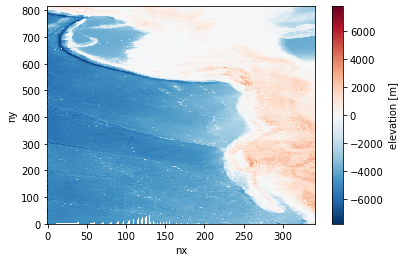

In [28]:
topo_out.elevation.plot()

In [9]:
topo

<xarray.Dataset>
Dimensions:      (nx: 10797, nxp: 10798, ny: 2099, nyp: 2100)
Coordinates:
    lon_centers  (nx) float64 -179.9 -179.9 -179.9 -179.9 ... 179.8 179.9 179.9
    lat_centers  (ny) float64 10.78 10.82 10.85 10.88 ... 80.65 80.68 80.72
    lon          (ny, nx) float64 -179.9 -179.9 -179.9 ... 179.8 179.9 179.9
    lat          (ny, nx) float64 10.78 10.78 10.78 10.78 ... 80.72 80.72 80.72
    lon_b        (nyp, nxp) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
    lat_b        (nyp, nxp) float64 10.77 10.77 10.77 ... 80.73 80.73 80.73
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    lat_corners  (nyp) float64 10.77 10.8 10.83 10.87 ... 80.63 80.67 80.7 80.73
    lon_corners  (nxp) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9
    elevation    (ny, nx) float32 -5.779e+03 -5.958e+03 ... -1.643e+03 -1.65e+03
    landmask     (ny, nx) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

In [4]:
from icecream import ic
numMethod='median'
njp = grid.dims['nyp']
nip = grid.dims['nxp']

superInt = int(2)
# create dataset
topo_out = xr.Dataset({
    topoVarName: xr.DataArray(
                data   = np.zeros((len(range(0,grid.dims['ny'],superInt)), len(range(0,grid.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'm'
                    }
                ),
    'landmask': xr.DataArray(
                data   = np.zeros((len(range(0,grid.dims['ny'],superInt)), len(range(0,grid.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'ocean fraction at T Cell Centers'
                    }
                ),
    'lon_corners': xr.DataArray( 
            data   = grid['lon_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_corners': xr.DataArray(
            data   = grid['lat_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lon_centers': xr.DataArray( 
            data   = grid['lon_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_centers': xr.DataArray(
            data   = grid['lat_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            )},
        #attrs = {'projection': grid.attrs['projection']}
    )

for i in range(0,nip-1,superInt):
    for j in range(0,njp-1,superInt):
        latMinInd = find_nearest(array = topo['lat_corners'].values, value = grid['lat_corners'].values[j,i])
        latMaxInd = find_nearest(array = topo['lat_corners'].values, value = grid['lat_corners'].values[j+1,i+1])
        lonMinInd = find_nearest(array = topo['lon_corners'].values, value = grid['lon_corners'].values[j,i])
        lonMaxInd = find_nearest(array = topo['lon_corners'].values, value = grid['lon_corners'].values[j+1,i+1])

        # clause in case we are dealing with datasets stored backwards - this matters because of the slice order xarray requires
        if lonMinInd > lonMaxInd:
            tem_ind = lonMinInd
            lonMinInd = lonMaxInd
            lonMaxInd = tem_ind

        # select bounding box for the topography dataset based on indices of the grid file corners - perform desired computation (median, mean, min, max) on matrix 
        if numMethod=='median':
            tem_topo = np.median(topo[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.median(topo['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True: 
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.median(topo[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.median(topo['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        if numMethod=='mean':
            tem_topo = np.mean(topo[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.mean(topo['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True: 
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.mean(topo[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.mean(topo['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        oj = int(j/superInt)
        oi = int(i/superInt)
        topo_out[topoVarName][oj,oi] = tem_topo
        topo_out['landmask'][oj,oi] = tem_lm

        # capture the index differences in case we reach the corner of a dataset and need to 'expand' our topography grid to fill the holes
        latDiffInd = abs(latMaxInd - latMinInd)
        lonDiffInd = abs(lonMaxInd - lonMinInd)

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'lonDiffInd' is not defined

In [243]:
abs(-9)

9

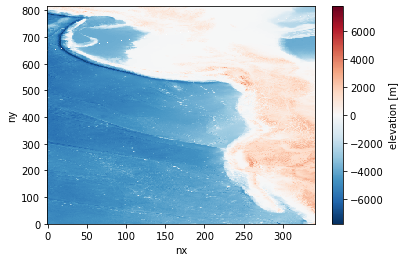

In [324]:
topo_out.elevation.plot()

In [277]:
regridTopo()

In [278]:
b

<xarray.Dataset>
Dimensions:    (nx: 20, ny: 30)
Coordinates:
    lon        (ny, nx) float64 ...
    lat        (ny, nx) float64 ...
Dimensions without coordinates: nx, ny
Data variables:
    elevation  (ny, nx) float64 ...

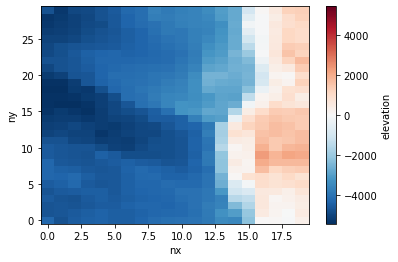

In [279]:
b.elevation.plot()